# VAE の 潜在変数のPC次元方向の分散分布をべき則に拘束
- Vanilla VAE は中間層に標準正規分布を仮定. PC分散はほぼ一様に (卒論)
- 潜在変数のサンプリングは, Reparametrization trick を用いて, 分散パラメータ用のネットワークの出力に標準正規分布からサンプリングしたランダムベクトルを要素毎にかける

<img src="figures/reparam.png" width=500px> https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24

- 通常VAEでは $\varepsilon_n \sim N(0, 1)$ のところを,  $\varepsilon_n \sim N(0, n^{-\gamma})$ とすることで, 潜在変数のPC次元分散分布を冪指数が$\gamma$ に比例したべき則になる.
    - 隠れ層のPC次元分布の冪指数は $2\gamma$ になる
```python
class VanillaVAE(pl.LightningModule):
    def _sample_hidden(self, mean, log_var):
        epsilon = torch.randn(mean.shape).to(mean.device)
        h = mean + epsilon * torch.exp(0.5 * log_var)
        return h

class ScaleFreeVAE(VanillaVAE):
    def _sample_hidden(self, mean, log_var):
        batch = mean.size(0)
        var_decay_1d = torch.tensor([n**(-self.power_law_gamma) for n in range(1, self.n_hid + 1)])
        var_decay = var_decay_1d.repeat(batch, 1)
        epsilon = (torch.randn(mean.shape) * var_decay).to(mean.device)
        h = mean + epsilon * torch.exp(0.5 * log_var)
        return h
```
- べき則エンコーディングの場合, 学習が早いことを確認(Adam使用時と同程度).
- Fashion-MNIST, n_hid=100, sgd の設定だと, $\gamma=1.2$ 付近が学習効率が最もよい

やりたいこと:
- 学習アルゴリズムはSGD (Adam は1epoch以内で学習が終了してしまい、結果がよく見れないため). -> CIFAR10 などのより難しいデータセット・深層なモデルで実施する
- VAE の中間層を特徴量とした分類器の敵対的サンプル(PGD, FGSM)に対する頑健性
- MLP に隠れ層のPC次元分布をベキに制限するアイデアを試してみる
    - 重み行列の初期値の分散を行ごとに減衰 ・ 出力にべき減衰(ReLU の傾きを変えることと同じ) などしてみる
- 入力データ(べき則を持つ)との関連性を調べる. 入力データがベキ的な傾向を持っているため、最初からLoss が低い可能性


In [1]:
sys.path.append("/home/shinzato/GitHub/power-law-research/power_law_research")
from datetime import datetime
import pytorch_lightning as pl

from models import LitVanillaVAE
from data_modules import FashionMNISTDataModule
from logzero import logger

tensorborad_dir = f"../log/exp01/{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}"
logger.info(f"Tensorboard directory: {tensorborad_dir}")
model = LitVanillaVAE(n_vis=784, n_hid=100, optimizer_name="sgd")
data_module = FashionMNISTDataModule(batch_size=128)
trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator="gpu",
    logger=pl.loggers.TensorBoardLogger(save_dir=f"tensorborad_dir/vanilla"),
)
trainer.fit(model, data_module)


[I 220925 18:50:35 928243199:10] Tensorboard directory: ../log/exp01/2022-09-25_18:50:35
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [2]:
import numpy as np
from utils import sample_neuron_firings, pca_variance

firings = sample_neuron_firings(model, data_module.train_dataloader())
pc_dim, pc_var = pca_variance(firings)
log_pc_dim, log_var = np.log(pc_dim), np.log(pc_var)


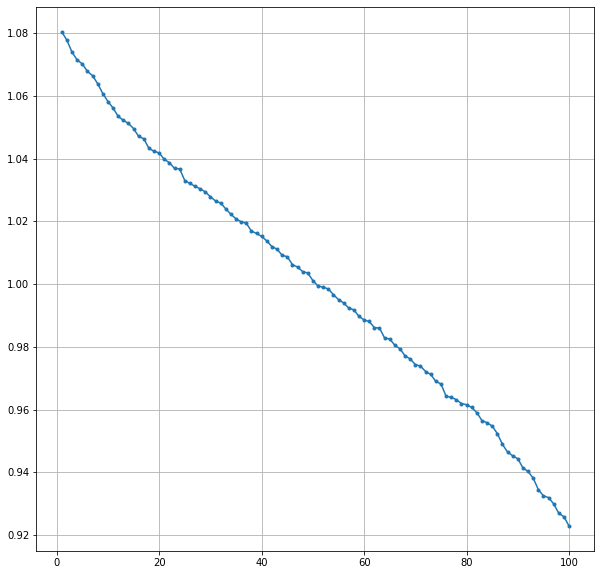

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.plot(pc_dim, pc_var, ".-")


- 通常のVAEでは, 中間層の出力のPC次元の分散はほぼ一様

In [4]:
from models import LitScaleFreeVAE

model = LitScaleFreeVAE(n_vis=784, power_law_gamma=0.5)
data_module = FashionMNISTDataModule(batch_size=128)
trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator="gpu",
    logger=pl.loggers.TensorBoardLogger(save_dir=f"{tensorborad_dir}/scalefree"),
)
trainer.fit(model, data_module)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/exp01/2022-09-25_18:50:35/scalefree/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

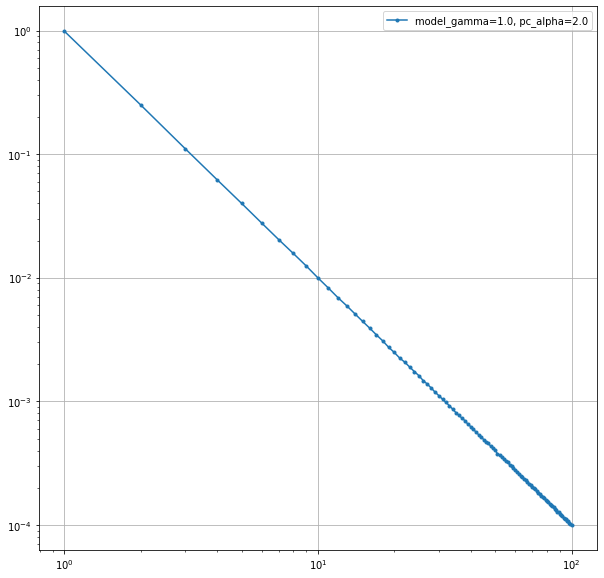

In [5]:
import numpy as np
from utils import sample_neuron_firings, pca_variance
import matplotlib.pyplot as plt

firings = sample_neuron_firings(model, data_module.train_dataloader())
pc_dim, pc_var = pca_variance(firings)
log_pc_dim, log_var = np.log(pc_dim), np.log(pc_var)
m, c = np.linalg.lstsq(np.vstack([log_pc_dim, np.ones(len(log_pc_dim))]).T, log_var, rcond=None)[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(pc_dim, pc_var, ".-", label=f"model_gamma={1.0}, pc_alpha={-m:.3}")
ax.legend()


15it [08:34, 34.27s/it]


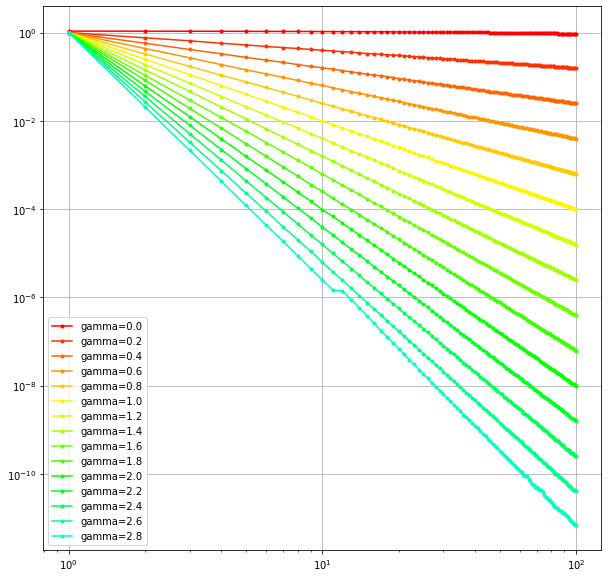

In [6]:
import matplotlib.cm as cm
import logging

from tqdm import tqdm

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")

for i, gamma in tqdm(enumerate([0.2 * i for i in range(15)])):
    model = LitScaleFreeVAE(n_vis=784, power_law_gamma=gamma)
    logger = pl.loggers.TensorBoardLogger(
        save_dir=f"{tensorborad_dir}/vary_gamma/{str(datetime.now())}_scalefree_gamma_{gamma:.2}"
    )
    logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
    data_module = FashionMNISTDataModule(batch_size=128)
    trainer = pl.Trainer(
        max_epochs=10, devices=1, accelerator="gpu", logger=logger, enable_progress_bar=False
    )
    trainer.fit(model, data_module)

    firings = sample_neuron_firings(model, data_module.train_dataloader())
    pc_dim, pc_var = pca_variance(firings)
    ax.plot(pc_dim, pc_var, ".-", label=f"gamma={gamma:.2}", color=cm.hsv(i / 30.0))
    ax.legend()


In [8]:
%load_ext tensorboard
%tensorboard --logdir $tensorborad_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1149413), started 1:51:22 ago. (Use '!kill 1149413' to kill it.)